<a href="https://colab.research.google.com/github/Erickrus/llm/blob/main/yue_tts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

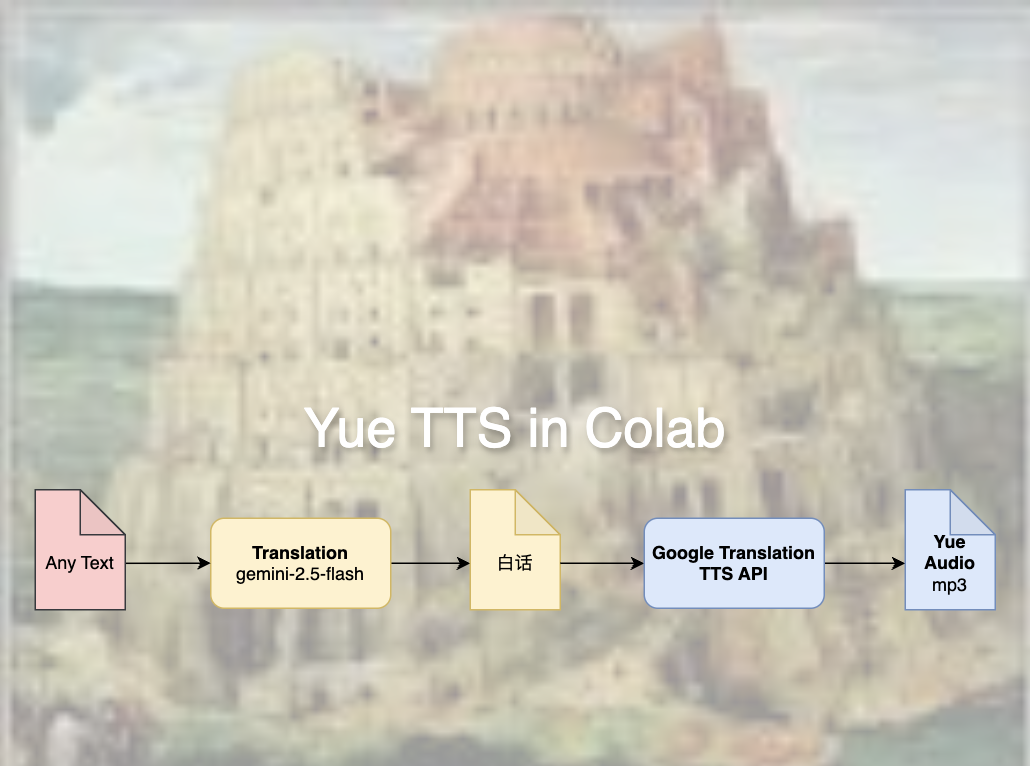

In [28]:
#@title check colab location
#@markdown Please select US based Colab Container to run Gemini

#@markdown If the result from ipinfo.io indicate you are not in US, then please create another Runtime.
import json
import requests
response = requests.get("http://ipinfo.io")
data = response.json()

if data['timezone'].find('America') < 0:
  print('Please select another Colab Runtime Container, invalid country')
  print(json.dumps(data, indent=2))

In [ ]:
#@title setup GOOGLE_API_KEY
#@markdown Gemini Flash 2.5 is used to generate the highlight
import getpass
import os
GOOGLE_API_KEY = getpass.getpass("Enter your GOOGLE_API_KEY: ")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

import google.generativeai as genai
genai.configure(api_key=GOOGLE_API_KEY)

In [32]:
#@title google_tts_api
# a slightly modified version of
# https://gitlab.com/labsoft-ai/google-translate-tts
import os
import re
import threading
import tempfile
import requests

# Constants
SPLIT_POINTS = [
    ",",
    ";",
    " i ",
    " ali ",
    " ili ",
    " međutim ",
    " zato ",
    " jer ",
    " kao ",
    " dok ",
    " kada ",
]
MAX_LENGTH = 200
TTS_URL = "https://translate.google.com/translate_tts"
AUDIO_SUFFIX = ".mp3"


def generate_url(text, lang):
    """
    Generate the URL for the Google TTS API.

    :param text: Text to be converted to speech.
    :param lang: Language code for the TTS.
    :return: URL string.
    """
    encoded_text = requests.utils.quote(text)
    return f"{TTS_URL}?ie=UTF-8&tl={lang}&client=tw-ob&q={encoded_text}"



def split_long_sentence(sentence, max_length=200):
    """
    Split a long sentence into parts, retaining punctuation at the end of each part.

    :param sentence: The sentence to split.
    :param max_length: Maximum length of each part.
    :return: List of sentence parts.
    """
    parts = []
    current_part = ""
    current_length = 0
    words = sentence.split()

    for word in words:
        # Check if adding the next word would exceed the max_length
        if current_length + len(word) + 1 > max_length:
            # Find the last suitable split point in the current part
            last_split_point = max(
                current_part.rfind(split_point) for split_point in SPLIT_POINTS
            )
            if last_split_point > 0:
                # Include the split point in the first part
                split_index = last_split_point + 1
                parts.append(current_part[:split_index].strip())
                current_part = current_part[split_index:].strip() + " "
            else:
                # If no suitable split point, split at the current position
                parts.append(current_part.strip())
                current_part = ""
            current_length = len(current_part)

        current_part += word + " "
        current_length += len(word) + 1

    # Add the final part if it's not empty
    if current_part:
        parts.append(current_part.strip())

    return parts


def split_text(text, max_length=MAX_LENGTH):
    """
    Split text into smaller parts.

    :param text: Text to be split.
    :param max_length: Maximum length of each part.
    :return: List of text parts.
    """
    sentences = re.split(r"(?<=[.!?]) +", text)
    parts = []

    for sentence in sentences:
        if len(sentence) <= max_length:
            parts.append(sentence)
        else:
            parts.extend(split_long_sentence(sentence, max_length))

    return parts


def get_tts(text, lang, output_filename):
    """
    Play text-to-speech for the given text and language.

    :param text: Text to be converted to speech.
    :param lang: Language code for the TTS.

    Raises:
    requests.RequestException: If there's an issue with the network or fetching the audio.
    IOError: If there's an issue writing the audio file.
    RuntimeError: If other unexpected issues occur.
    """
    parts = split_text(text)

    for part in parts:
        url = generate_url(part, lang)
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            with tempfile.NamedTemporaryFile(
                delete=False, suffix=AUDIO_SUFFIX
            ) as audio_file:
                audio_file.write(response.content)
                temp_audio_file = audio_file.name
            # print(f"mv {temp_audio_file} {output_filename}")
            os.system(f"mv {temp_audio_file} {output_filename}")

        except requests.RequestException as e:
            print(f"Error fetching audio: {e}")
        except IOError as e:
            print(f"Error writing audio file: {e}")
        except RuntimeError as e:
            print(f"Unexpected error: {e}")

import google.generativeai as genai

def translate(text: str, model_name: str = 'gemini-2.5-flash', oral=False) -> str:
  oral_text = " and be more oral" if oral else ""
  try:
    model = genai.GenerativeModel(model_name)
    prompt = f"""
Translate the following Simplified Chinese text to Cantonese (Do not include Pinyin letters{oral_text}. Do not include alternatives or explanations):
{text}
Cantonese translation:"""
    response = model.generate_content(prompt)
    return response.text
  except Exception as e:
    return f"Error during translation: {e}"

In [ ]:
#@title TTS
from IPython.display import Audio

# Example usage:
TEXT = "今天心情不错啊，晚上出去吃夜宵吗？" #@param {"type": "string"}
ORAL = True #@param {"type": "boolean"}
trans_text = translate(TEXT.replace("-","_"), oral=ORAL)

oral_ind = "口语" if ORAL else "书面"
print(f"Original  : {TEXT}")
print(f"Translated: {trans_text}")

proposed_filename = f"{oral_ind}-{TEXT}-{trans_text}.mp3".replace("?", "_").replace("/", "_").replace('\\',"_").replace(' ','_').replace("'",'_').replace("\n","_")
audio_file_path = os.path.join("/content", proposed_filename)
get_tts(trans_text, 'yue', audio_file_path)
Audio(audio_file_path)

In [ ]:
#@title Replay
import os
from IPython.display import Audio, display, HTML
import ipywidgets as widgets

# 1. List all MP3 files in the /content/ directory (or specify your path)
def list_mp3_files(directory="/content/"):
    mp3_files = [f for f in os.listdir(directory) if f.lower().endswith('.mp3')]
    return mp3_files

# 2. Create HTML select dropdown and play button
def create_audio_player():
    mp3_files = list_mp3_files()
    if not mp3_files:
        display(HTML("<p>No MP3 files found in the directory.</p>"))
        return

    # Create dropdown widget
    dropdown = widgets.Dropdown(
        options=mp3_files,
        description='<b>Select an Audio</b>:',
        style={'description_width': 'initial'}
    )

    # Create play button
    play_button = widgets.Button(description="Replay")

    # 3. Define function to play selected MP3
    def play_mp3(b):
        selected_file = dropdown.value
        if selected_file:
            audio = Audio(f"/content/{selected_file}")
            oral, text, translated_text = selected_file.split("-")
            translated_text = translated_text[:-4]
            print(f"Oral      : {oral}")
            print(f"Original  : {text}")
            print(f"Translated: {translated_text}")
            display(audio)

    # Link button click to play function
    play_button.on_click(play_mp3)

    # Display widgets
    display(dropdown)
    display(play_button)

# Run the audio player
create_audio_player()

In [39]:
#@title Download
import os
from google import colab
import datetime
timestamp = datetime.datetime.now().strftime("%Y%d%m")
zip_filename = f"yue_tts_{timestamp}.zip"
os.system(f"rm -f {zip_filename}")
os.system(f"zip {zip_filename} *.mp3")
colab.files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>